In [ ]:
!pip install pandas_ta
!pip install neat-python
!pip install scikit-bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 14.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.4 MB/s eta 0:00:00
  Created wheel for scikit-bio: filename=scikit_bio-0.5.8-cp310-cp310-linux_x86_64.whl size=2670680 sha256=9c525e60934407499dc0d2b7cc5200e26565f31a39f5d30c382e7acc0f9253ac
  Stored in directory: /root/.cache/pip/wheels/e8/5c/a6/323c02049541684538df2610cc63f0157ecb8995cac53667d3
  Created wheel for hdmedians: filename=hdmedians-0.14.2-cp310-cp310-linux_x86_64.whl size=670766 sha256=1119bab1fae7f79302c880a152c02c563f0fa768de68bdbf75354960e11c2b29
  Stored in directory: /root/.cache/pip/wheels/82/8f/0d/0c61130cfad119482ebb95ae

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
use_collab = True
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'

In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import neat
import string
from skbio.diversity.alpha import pielou_e


In [ ]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [ ]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


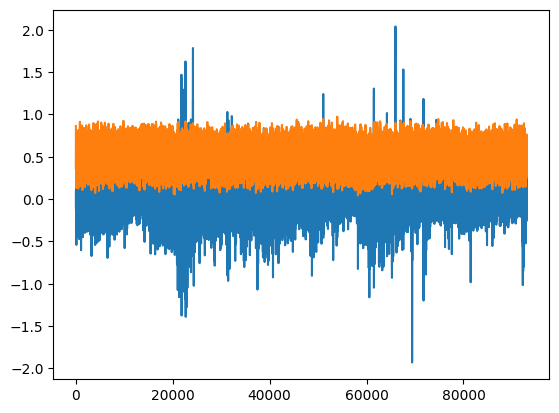

In [ ]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [ ]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [ ]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [ ]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [204]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(5)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0.0
    trade_direction = 0
    cash_out_val = 0
    acount_bal = 0
    trade_max = 0
    trade_risk = 0


    for count in range(rand, rand+60000):
        state = np.concatenate((INDICATORS[count],trade_info))
        outputs = net.activate(state)
        risk =  np.clip(abs(outputs[4]), .01, 1)
        action = np.argmax(outputs[:3])
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count+1]
        cash_out_val = 0

        if buy:
          cash_out_val = trade_value
          trade_risk = risk
          trade_value = (cur_move*1)*trade_risk
          trade_direction = 1
          trade_timer = 0
          trade_max = trade_value

        elif sell:
          cash_out_val = trade_value
          trade_risk = risk
          trade_value = (cur_move*-1)*trade_risk
          trade_direction = -1
          trade_timer = 0
          trade_max = trade_value

        elif cash_out:
          cash_out_val = trade_value
          trade_value = 0
          trade_direction = 0
          trade_timer = 0
          trade_max = 0
          trade_risk = 0
        else:
          trade_value += (cur_move*trade_direction)*trade_risk
          trade_timer += .05
          trade_max = max(trade_max,trade_value)



        acount_bal += cash_out_val
        if buy or sell:
          acount_bal -= .05
        elif trade_value < 0:
          acount_bal -= .01
        else:
          acount_bal -= .005


        trade_info = (trade_value,trade_direction,trade_timer,trade_max,trade_risk)


        if debug:
          print([trade_info,acount_bal])

        if acount_bal<-5 or (trade_value<0 and trade_timer>2):
          return count-rand if count-rand != 1000 else 0


    return count-rand if count-rand != 1000 else 0

In [205]:
def eval_genomes(genomes, config):
  rand = random.randint(10000, 20000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [206]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [ ]:
winner = p.run(eval_genomes,100)


 ****** Running generation 0 ****** 

Population's average fitness: 138.29333 stdev: 353.74559
Best fitness: 3219.00000 - size: (5, 18) - species 1 - id 149
Average adjusted fitness: 0.043
Mean genetic distance 1.928, standard deviation 0.264
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.386 sec

 ****** Running generation 1 ****** 

Population's average fitness: 177.82000 stdev: 305.24899
Best fitness: 1686.00000 - size: (5, 18) - species 1 - id 76
Average adjusted fitness: 0.105
Mean genetic distance 2.091, standard deviation 0.267
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.188 sec (4.787 average)

 ****** Running generation 2 ****** 

Population's average fitness: 276.14667 stdev: 370.16008
Best fitness: 1412.00000 - size: (5, 18) - species 1 - id 438
Average adjusted fitness: 0.196
Mean genetic distance 2.067, standard deviation 0.289
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.

In [189]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [190]:
run_env_loop(net,30000,True)

[(-0.0, -1, 0, -0.0, 0.0), -0.05]
[(0.0, -1, 0.05, -0.0, 0.0), -0.055]
[(0.0, -1, 0.1, -0.0, 0.0), -0.06]
[(0.0, -1, 0.15000000000000002, -0.0, 0.0), -0.065]
[(0.0, -1, 0.2, -0.0, 0.0), -0.07]
[(0.0, -1, 0.25, -0.0, 0.0), -0.07500000000000001]
[(0.0, -1, 0.3, -0.0, 0.0), -0.08000000000000002]
[(0.0, -1, 0.35, -0.0, 0.0), -0.08500000000000002]
[(0.0, -1, 0.39999999999999997, -0.0, 0.0), -0.09000000000000002]
[(0.0, -1, 0.44999999999999996, -0.0, 0.0), -0.09500000000000003]
[(0.0, -1, 0.49999999999999994, -0.0, 0.0), -0.10000000000000003]
[(0.0, -1, 0.5499999999999999, -0.0, 0.0), -0.10500000000000004]
[(0.0, -1, 0.6, -0.0, 0.0), -0.11000000000000004]
[(0.0, -1, 0.65, -0.0, 0.0), -0.11500000000000005]
[(0.0, -1, 0.7000000000000001, -0.0, 0.0), -0.12000000000000005]
[(0.0, -1, 0.7500000000000001, -0.0, 0.0), -0.12500000000000006]
[(0.0, -1, 0.8000000000000002, -0.0, 0.0), -0.13000000000000006]
[(0.0, -1, 0.8500000000000002, -0.0, 0.0), -0.13500000000000006]
[(0.0, -1, 0.9000000000000002, 

1990

In [191]:


def get_weights(connections, node_name,letter):
    node_weight = ""

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                node_weight = node_weight + from_node_name + " * " + str(weight) + " + "


    return(node_weight)





In [ ]:
nodes = winner.nodes
conec = winner.connections
node_list = []
letter_dict = dict()
count = 0



for index, node in nodes.items():
    letter_dict[index] = string.ascii_uppercase[count]
    count += 1

for index, node in nodes.items():
    node_name = letter_dict[index]
    activation = node.activation
    bias = str(node.bias) + ")"
    front = node_name + " = " + activation + "("
    weights = get_weights(conec,node_name,letter_dict)
    node_list.append((front+weights+bias))

node_list.reverse()






In [ ]:
print(winner)

Key: 7604
Fitness: 39.5992013093501
Nodes:
	0 DefaultNodeGene(key=0, bias=0.040860372320391844, response=1.0, activation=identity, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-2.4304265398230833, response=1.0, activation=abs, aggregation=sum)
	603 DefaultNodeGene(key=603, bias=-0.7377609977359878, response=1.0, activation=abs, aggregation=sum)
	606 DefaultNodeGene(key=606, bias=1.6444411532967487, response=1.0, activation=identity, aggregation=sum)
	607 DefaultNodeGene(key=607, bias=0.8025720723073365, response=1.0, activation=abs, aggregation=sum)
	608 DefaultNodeGene(key=608, bias=-0.9721775320973074, response=1.0, activation=abs, aggregation=sum)
	611 DefaultNodeGene(key=611, bias=1.7225460985763466, response=1.0, activation=abs, aggregation=sum)
	2990 DefaultNodeGene(key=2990, bias=-0.3179116165217865, response=1.0, activation=relu, aggregation=sum)
	3041 DefaultNodeGene(key=3041, bias=0.5474211028748757, response=1.0, activation=relu, aggregation=sum)
Connections:
	DefaultConn

In [ ]:
for item in node_list:
       print(item)

I = relu(P1 * 1.9319062315476767 + H * 0.8415230280414117 + 0.5474211028748757)
H = relu(P2 * 0.37733104827453345 + -0.3179116165217865)
G = abs(1.7225460985763466)
F = abs(P2 * 2.752470078657781 + I * 0.6381712072630762 + -0.9721775320973074)
E = abs(G * -2.1194013010028017 + P2 * 0.46884834168093004 + 0.8025720723073365)
D = identity(P2 * 1.1191686921634076 + H * 3.9513831135425113 + B * 1.6536591788097703 + 1.6444411532967487)
C = abs(P1 * 0.6320701976923242 + P2 * 0.8517532705477244 + D * -0.7749555067716818 + -0.7377609977359878)
B = abs(E * -1.447717383921146 + F * -1.5838456978397466 + P1 * 1.4149285592498657 + -2.4304265398230833)
A = identity(P1 * -5.332177219676623 + 0.040860372320391844)
